## 导入第三方库

In [1]:
# 导入第三方库
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import time
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from shapely import wkt
import folium
from folium import GeoJson
import time
import os
from shapely.geometry import Point, box
import pandas as pd
from shapely.geometry import LineString, Point

## 数据预处理

In [11]:
'''
    数据预处理参数设置
'''
# 交通区域的边界文件
boundary_path = 'data/ad_county.csv'

# od数据的路径
od_path = 'data/t_bd_od.csv'

# 速度数据路径
speed_path = 'data/交通-九峰街道.csv'

# 网格大小（KM）
grid_size_km = 1

# 经纬度到距离的转换常数
degree_to_km = 111.32

# 区域中心坐标
cent = [30.434140477236866, 114.51135311054612]

# 速度的时间跨度
T_speed = 7 * 24

# 分块处理大小
chunksize = 1000000

# 存放生成数据集的路径
dataset_path = './批量处理的最终数据集/'

# 调试模式
is_test = False



def data_process_all(degree_to_km , grid_size_km, cent, T_speed, chunksize, boundary_path, od_path, speed_path, dataset_path,is_test):
    '''
    完整的数据预处理流程，生成OD数据集和Speed数据集
    :param degree_to_km:
    :param grid_size_km:
    :param cent:
    :param T_speed:
    :param chunksize:
    :param boundary_path:
    :param od_path:
    :param speed_path:
    :param dataset_path:
    :return: speed_dataset, od_dataset
    '''
    '''
        划分交通区域
    '''
    start_time = time.time()
    print(f"交通区域网格划分...")
    # 边界数据
    df = pd.read_csv(boundary_path, encoding='utf-8')
    
    # 创建地图对象，设定一个初步的中心点和缩放级别
    m = folium.Map(location=cent, zoom_start=12)
    
    # 设置边界样式
    def style_function(feature):
        return {
            'fillColor': 'blue',
            'color': 'black',
            'weight': 2,
            'fillOpacity': 0
        }
    
    # 绘制区域
    for index, row in df.iterrows():
        geometry = wkt.loads(row['wkt'])
        geo_json = GeoJson(geometry, style_function=style_function)
        geo_json.add_to(m)
    
    # 用于存储网格数据（ID, 最小经度, 最小纬度, 最大经度, 最大纬度, 中心经度, 中心纬度）
    grid_data = []
    
    # 设置网格边界样式
    def grid_style(feature):
        return {
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0
        }
    
    # 遍历每行数据，解析WKT并绘制区域
    for index, row in df.iterrows():
        try:
            geometry = wkt.loads(row['wkt'])
    
            # 获取区域边界框，确定最小经度、最大经度、最小纬度、最大纬度
            minx, miny, maxx, maxy = geometry.bounds
    
            # 计算纬度和经度方向上的网格大小
            lat_grid_size = grid_size_km / degree_to_km  # 计算纬度方向上的网格大小（度）
    
            # 获取当前区域的中心纬度，动态计算经度网格大小
            center_lat = (miny + maxy) / 2
            lon_grid_size = grid_size_km / (degree_to_km * np.cos(np.radians(center_lat)))  # 经度方向上的网格大小（度）
    
            # 计算区域内的网格
            latitudes = np.arange(miny, maxy, lat_grid_size)
            longitudes = np.arange(minx, maxx, lon_grid_size)
    
            # 划分网格区域，并绘制每个网格区域
            region_id = 0
            for lat in latitudes:
                for lon in longitudes:
                    # 创建一个小网格框
                    grid_box = box(lon, lat, lon + lon_grid_size, lat + lat_grid_size)
    
                    # 判断该网格是否完全位于原始区域内，使用intersection裁剪
                    intersection = geometry.intersection(grid_box)
    
                    # 如果交集的几何形状是有效的并且完全包含网格（即交集为网格本身）
                    if intersection.is_valid and intersection.area > 0:
                        geo_json = GeoJson(intersection, style_function=grid_style)
    
                        # 创建弹出窗口显示区域ID和经纬度范围
                        popup_content = f"Region ID: {region_id}\nLat Range: ({lat}, {lat + lat_grid_size})\nLon Range: ({lon}, {lon + lon_grid_size})"
                        geo_json.add_child(folium.Popup(popup_content))
    
                        geo_json.add_to(m)
    
                        # 计算网格中心点
                        center_lon = lon + lon_grid_size / 2
                        center_lat = lat + lat_grid_size / 2
    
                        # 添加网格的ID、经纬度范围和中心点到CSV数据列表
                        grid_data.append({
                            'Region ID': region_id,
                            'Min Longitude': lon,
                            'Min Latitude': lat,
                            'Max Longitude': lon + lon_grid_size,
                            'Max Latitude': lat + lat_grid_size,
                            'Center Longitude': center_lon,
                            'Center Latitude': center_lat
                        })
    
                        # 更新区域ID
                        region_id += 1
    
        except Exception as e:
            print(f"Error processing row {index}: {e}")

    grid_data = pd.DataFrame(grid_data)

    end_time = time.time()
    time_difference_seconds = end_time - start_time
    time_difference_minutes = time_difference_seconds / 60
    print(f"交通区域网格划分完成，耗时{time_difference_minutes:.2f}min")
    
    '''
        OD数据网格映射
    '''
    start_time = time.time()
    print("\nOD数据网格映射...")

    # 读取Grid数据并重命名列以便后续操作
    grid_data.columns = ['region_id', 'min_lng', 'min_lat', 'max_lng', 'max_lat', 'center_lng', 'center_lat']

    from rtree import index

    # 构建R-tree空间索引
    spatial_index = index.Index()
    for idx, row in grid_data.iterrows():
        bbox = (row['min_lng'], row['min_lat'], row['max_lng'], row['max_lat'])
        spatial_index.insert(int(row['region_id']), bbox)

    # 函数：查找点对应的区域ID
    def find_region_id(lng, lat):
        point = Point(lng, lat)
        candidate_regions = list(spatial_index.intersection((lng, lat, lng, lat)))
        for region_id in candidate_regions:
            row = grid_data[grid_data['region_id'] == region_id].iloc[0]
            bbox = box(row['min_lng'], row['min_lat'], row['max_lng'], row['max_lat'])
            if bbox.contains(point):
                return region_id
        return -1

    # 函数：根据经纬度匹配区域ID,返回区域ID和区域中心坐标
    def match_region_id(lng, lat, grid_data):
        region = grid_data[(grid_data['min_lng'] <= lng) & (lng <= grid_data['max_lng']) &
                           (grid_data['min_lat'] <= lat) & (lat <= grid_data['max_lat'])]
        return region['region_id'].values[0] if not region.empty else -1

    # 分块读取并处理
    processed_data = []  # 用于存储处理后的数据
    total_rows = 0  # 记录总行数
    chunk_count = 0  # 记录分块计数

    if is_test:
        chunksize = 10000
        
    for chunk in pd.read_csv(od_path, encoding='utf-8', chunksize=chunksize, on_bad_lines='skip'):
        chunk_count += 1
        # 矢量化匹配区域ID
        chunk['start_region_id'] = chunk.apply(lambda row: find_region_id(row['start_center_lnt'], row['start_center_lat']), axis=1)

        chunk['end_region_id'] = chunk.apply(lambda row: find_region_id(row['end_center_lnt'], row['end_center_lat']), axis=1)

        # 筛选有效数据
        filtered_chunk = chunk[(chunk['start_region_id'] != -1) & (chunk['end_region_id'] != -1)]

        processed_data.append(filtered_chunk)

        total_rows += len(filtered_chunk)

        if is_test:
            if chunk_count == 1:
                break

    print(f"共处理{chunk_count}块数据")

    end_time = time.time()
    time_difference_seconds = end_time - start_time
    time_difference_minutes = time_difference_seconds / 60
    print(f"OD数据网格映射完成，耗时{time_difference_minutes:.2f}min")

    # 合并所有分块数据
    od_with_grid = pd.concat(processed_data, ignore_index=True)

    '''
        OD数据集生成
    '''
    start_time = time.time()
    print("\nOD数据集生成...")
    # 已获取到网格ID的OD数据
    df = od_with_grid

    # 获取所有唯一的区域ID并排序
    all_regions = sorted(set(df['start_region_id'].unique()).union(set(df['end_region_id'].unique())))
    N = len(all_regions)  # 区域总个数

    # 创建区域ID到索引的映射
    region_to_index = {region: idx for idx, region in enumerate(all_regions)}

    # 获取唯一的日期和小时
    unique_dates = df['date_format'].unique()
    unique_hours = sorted(df['hour'].unique())

    # 计算时间步长 T
    T = len(unique_dates) * len(unique_hours)

    # 创建一个 [T, N, N] 的空矩阵
    od_matrix = np.zeros((T, N, N))

    # 将日期和小时映射到时间步长
    date_to_idx = {date: idx for idx, date in enumerate(unique_dates)}
    hour_to_idx = {hour: idx for idx, hour in enumerate(unique_hours)}

    # 将数据按日期、小时、出发区域、到达区域进行分组并计算流量
    for _, row in df.iterrows():
        start_region_idx = region_to_index[row['start_region_id']]
        end_region_idx = region_to_index[row['end_region_id']]
        date_idx = date_to_idx[row['date_format']]
        hour_idx = hour_to_idx[row['hour']]

        # 计算对应的时间步长索引
        time_step_idx = date_idx * len(unique_hours) + hour_idx

        if row['cnt'] <= 64:  # 合法交通数量
            # 更新对应时间步长和区域对的流量
            od_matrix[time_step_idx, start_region_idx, end_region_idx] += row['cnt']
        else:
            continue
    
    end_time = time.time()
    time_difference_seconds = end_time - start_time
    time_difference_minutes = time_difference_seconds / 60
    print(f"OD数据集生成完成，耗时{time_difference_minutes:.2f}min")

    '''
        速度数据点网格映射
    '''
    start_time = time.time()
    print("\nSpeed数据网格映射...")
    # 读取CSV数据
    speed_data = pd.read_csv(speed_path, encoding='utf-8')
    # 测试语句
    if is_test:
        speed_data = speed_data[:100]

    grid =  grid_data

    # 定义函数，用于判断点是否在网格范围内
    def get_region_ids_from_wkt(wkt, grid):
        # 将wkt字符串解析为LineString对象
        line = LineString(
            [tuple(map(float, coord.split())) for coord in wkt.replace("LINESTRING (", "").replace(")", "").split(", ")])
        region_ids = []
    
        # 遍历所有网格
        for _, row in grid.iterrows():
            min_lon, min_lat, max_lon, max_lat = row['min_lng'], row['min_lat'], row['max_lng'], row[
                'max_lat']
            # 检查每个点是否在网格范围内
            for point in line.coords:
                if min_lon <= point[0] <= max_lon and min_lat <= point[1] <= max_lat:
                    region_ids.append(row['region_id'])
    
        # 去重后返回
        return list(set(region_ids))
    
    
    # 应用到数据中
    speed_data['grid_list'] = speed_data['wkt'].apply(lambda wkt: get_region_ids_from_wkt(wkt, grid))
    
    # 输出前几行检查结果

    end_time = time.time()
    time_difference_seconds = end_time - start_time
    time_difference_minutes = time_difference_seconds / 60
    print(f"Speed数据网格映射完成，耗时{time_difference_minutes:.2f}min")
    
    '''
        速度数据集生成
    '''
    start_time = time.time()
    print("\nSpeed数据集生成...")

    data = speed_data
    
    # 获取唯一的区域ID
    region_ids = set()
    for grid_list in data['grid_list']:
        if isinstance(grid_list, str):
            # 如果是字符串，先去除方括号，再分割并转换为整数
            region_ids.update(map(lambda x: int(float(x)), grid_list.strip("[]").split(',')))
        elif isinstance(grid_list, list):
            # 如果是列表，直接将元素转换为整数
            region_ids.update(map(lambda x: int(float(x)), grid_list))

    region_ids = sorted(region_ids)

    # 创建一个字典，用于存储每个区域每个时间步的特征
    T = T_speed
    N = len(region_ids)  # 区域数
    C = 2  # 特征数：congest_speed 和 Region ID
    
    # 初始化一个空的三维数组，形状为 [T, N, C]
    speed_matrix = np.zeros((T, N, C))
    
    # 额外的数组，用于跟踪每个区域在每个时间步的填充次数
    count_array = np.zeros((T, N))  # 用于统计每个时间步每个区域被填充的次数
    
    # 遍历数据填充 speed_matrix
    for _, row in data.iterrows():
        weekday = row['weekday']  # 星期几
        hour_info = row['hour_info']  # 小时信息
        time_step = (weekday - 1) * 24 + hour_info  # 计算时间步 (从0到167)

        
        congest_speed = row['congest_speed']  # 拥堵速度
        grid_list = row['grid_list']
        if isinstance(grid_list, str):
            region_ids_for_row = list(map(lambda x: int(float(x.strip())), grid_list.strip("[]").split(',')))
        elif isinstance(grid_list, list):
            region_ids_for_row = list(map(lambda x: int(float(x)), grid_list))
        
    
    
        # 填充每个区域的 congest_speed 和 Region ID
        for region_id in region_ids_for_row:
            region_idx = region_ids.index(region_id)  # 找到该区域ID的索引
    
            # 如果该位置未被填充（即为 0），直接填充
            if speed_matrix[time_step, region_idx, 0] == 0:
                speed_matrix[time_step, region_idx, 0] = congest_speed  # 填充 congest_speed
                speed_matrix[time_step, region_idx, 1] = region_id  # 填充 Region ID
                count_array[time_step, region_idx] = 1  # 记录该位置已被填充一次
            else:
                # 如果已经被填充，则进行累加
                speed_matrix[time_step, region_idx, 0] += congest_speed
                count_array[time_step, region_idx] += 1  # 累加填充次数
    
    # 在所有数据处理完成后，计算每个区域在每个时间步的平均值
    for t in range(T):
        for n in range(N):
            if count_array[t, n] > 0:
                # 计算并填充平均值
                speed_matrix[t, n, 0] /= count_array[t, n]  # 平均拥堵速度
                # Region ID 不需要修改，因为它已在第一次填充时确定

    end_time = time.time()
    time_difference_seconds = end_time - start_time
    time_difference_minutes = time_difference_seconds / 60
    print(f"Speed数据集生成完成，耗时{time_difference_minutes:.2f}min")

    '''
        数据集对齐
    '''
    start_time = time.time()
    print("\n数据集对齐...")
    speed = speed_matrix
    speed_index = speed[0,:,1]
    speed_index = speed_index.astype(int)  # 或者使用 np.floor(speed_index).astype(int)
    
    od = od_matrix
    
    od_index = all_regions

    # 找出共有的区域ID
    common_region_ids = np.intersect1d(speed_index, od_index)

    # 获取共有区域ID的索引
    speed_filtered_indices = np.isin(speed_index, common_region_ids)  # speed 中共有区域的索引
    od_filtered_indices = np.isin(od_index, common_region_ids)  # od 中共有区域的索引

    # 筛选 speed 和 OD 数据集，仅保留这些区域
    filtered_speed = speed[:, speed_filtered_indices, :]
    filtered_od = od[:, od_filtered_indices, :][:, :, od_filtered_indices]


    T_od = filtered_od.shape[0]
    # 将每个时间步的 N x N 矩阵的对角线置为 0
    for t in range(T_od):
        np.fill_diagonal(filtered_od[t], 0)
    
    end_time = time.time()
    time_difference_seconds = end_time - start_time
    time_difference_minutes = time_difference_seconds / 60
    print(f"数据集对齐完成，耗时{time_difference_minutes:.2f}min")


    if not is_test:

        # 检查目录是否存在，如果不存在则创建
        if not os.path.exists(dataset_path):
            os.makedirs(dataset_path)

        np.save(dataset_path+'Speed_完整批处理note.npy', filtered_speed[..., 0])
        np.save(dataset_path+'OD_完整批处理note.npy', filtered_od)


    print(f"\n已生成最终Speed数据集 {filtered_speed[..., 0].shape}")
    print(f"已生成最终OD数据集: {filtered_od.shape}")

    return filtered_speed[..., 0], filtered_od

# 数据预处理
speed, od = data_process_all(degree_to_km , grid_size_km, cent, T_speed, chunksize, boundary_path, 
                                                od_path, speed_path, dataset_path,is_test)

交通区域网格划分...
交通区域网格划分完成，耗时0.01min

OD数据网格映射...
共处理25块数据
OD数据网格映射完成，耗时163.87min

OD数据集生成...
OD数据集生成完成，耗时8.23min

Speed数据网格映射...
Speed数据网格映射完成，耗时10.53min

Speed数据集生成...
Speed数据集生成完成，耗时0.04min

数据集对齐...
数据集对齐完成，耗时0.00min

已生成最终Speed数据集 (168, 110)
已生成最终OD数据集: (168, 110, 110)


## 加载数据集

In [15]:
seed = 42
BATCH = 32

# Load_data函数
def load_data(speed, od, seed, BATCH):
    '''
    数据集处理函数，返回dataloader以及时域、频域差距等
    :param speed: 速度数据集
    :param od: OD数据集
    :param seed: 种子
    :param BATCH: 批次大小
    :return: train_loader, val_loader, test_loader, x_temp, x_freq, N, speed_scaler 
    '''
    # 设置随机种子
    set_seed(seed)

    # 获取数据长度 T
    T, N = speed.shape

    # 按顺序划分数据
    train_size = int(T * 0.6)
    val_size = int(T * 0.2)

    # 顺序划分索引
    train_indices = np.arange(0, train_size)
    val_indices = np.arange(train_size, train_size + val_size)
    test_indices = np.arange(train_size + val_size, T)

    # 按索引划分数据
    speed_train, speed_val, speed_test = speed[train_indices], speed[val_indices], speed[test_indices]
    od_train, od_val, od_test = od[train_indices], od[val_indices], od[test_indices]


    # 在训练集上计算 OD 出发总量
    od_train_production = np.sum(od_train, axis=-1)  # 形状 [T_train, N]

    # 计算每个区域在 T_train 时间步的平均速度和平均出发总量
    mean_speed = np.mean(speed_train, axis=0)  # 每个区域的平均速度 [N,]
    mean_production = np.mean(od_train_production, axis=0)  # 每个区域的平均出发总量 [N,]
    
    # 计算时域差距
    temporal = (mean_production - mean_speed).astype(float)  # [N,]

    # 计算频域差距
    speed_freq = get_X_Freq(speed)  # 形状 [N,]
    od_production = np.sum(od, axis=-1)
    od_freq = get_X_Freq(od_production)  # 形状 [N,]
    freq = (od_freq - speed_freq).astype(float)

    # 频域差距、时域差距、speed归一化
    temp_scaler = MinMaxScaler()
    x_temp = temp_scaler.fit_transform(temporal.reshape(-1, 1))
    x_temp = np.squeeze(x_temp, axis=-1)  # [N,]
    
    freq_scaler = MinMaxScaler()
    x_freq = freq_scaler.fit_transform(freq.reshape(-1, 1))
    x_freq = np.squeeze(x_freq, axis=-1)  # [N,]
    
    speed_scaler = MinMaxScaler()
    train_data = speed_scaler.fit_transform(speed_train.reshape(-1, 1)).reshape(speed_train.shape)
    val_data = speed_scaler.transform(speed_val.reshape(-1, 1)).reshape(speed_val.shape)
    test_data = speed_scaler.transform(speed_test.reshape(-1, 1)).reshape(speed_test.shape)


    # tensor张量
    train_data = torch.tensor(train_data, dtype=torch.float32)
    val_data = torch.tensor(val_data, dtype=torch.float32)
    test_data = torch.tensor(test_data, dtype=torch.float32)

    train_target = torch.tensor(od_train, dtype=torch.float32)
    val_target = torch.tensor(od_val, dtype=torch.float32)
    test_target = torch.tensor(od_test, dtype=torch.float32)



    # 生成Dataloader
    train_dataset = TensorDataset(train_data, train_target)
    val_dataset = TensorDataset(val_data, val_target)
    test_dataset = TensorDataset(test_data, test_target)

    train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH)
    test_loader = DataLoader(test_dataset, batch_size=BATCH)
    
    print("数据集已加载")
    return train_loader, val_loader, test_loader, x_temp, x_freq, N, speed_scaler

def get_X_Freq(seq):
    '''
    用于计算序列的频域均值
    :param seq: 输入的OD或Speed数据集序列 --> [T,N]
    :return freq: 频域均值 --> [N,]
    '''
    # 数据分割
    T, N = seq.shape
    train_size = int(T * 0.6)
    val_size = int(T * 0.2)

    train_indices = np.arange(train_size)
    val_indices = np.arange(train_size, train_size + val_size)
    test_indices = np.arange(train_size + val_size, T)

    seq_train, seq_val, seq_test = seq[train_indices], seq[val_indices], seq[test_indices]

    # 参数设置
    K = 50  # DCT基数
    J = 3  # 贪婪选择的周期数

    # 离散余弦变换 (DCT)
    dct_coefficients = np.zeros((K, N))  # 保存 top K 的 DCT 系数
    selected_periods = []  # 存储每个区域贪婪选择的周期信息

    for i in range(N):
        # 对每个区域进行 DCT
        dct_result = dct(seq_train[:, i], type=2, norm='ortho')

        # 计算 DCT 系数的幅值
        dct_magnitude = np.abs(dct_result)
        top_k_indices = np.argsort(dct_magnitude)[::-1][:K]  # 幅值从大到小排序，取前 K 个

        # 计算初始 top-k 周期值
        top_k_periods = [T / k if k != 0 else float('inf') for k in top_k_indices]  # k=0 时周期为无穷大

        # 保存 top K 系数
        dct_coefficients[:K, i] = dct_result[top_k_indices]

        # 贪婪选择最优的 J 个周期
        selected_freqs = []
        selected_amps = []
        selected_phases = []

        for j in range(J):
            best_freq = None
            best_amp = None
            best_phase = None
            min_val_error = float('inf')  # 初始化最小验证误差为无穷大

            for k in top_k_indices:
                if k in selected_freqs:  # 跳过已选择的频率
                    continue

                # 当前频率对应的 DCT 系数
                coeff = dct_result[k]
                amp = np.abs(coeff)
                phase = np.angle(coeff)
                freq = k / T  # 归一化频率

                # 重建信号
                t_train = np.arange(train_size)
                reconstructed_signal = np.zeros_like(t_train, dtype=np.float64)

                # 加上已选频率和当前频率对应的信号分量
                for f, a, p in zip(selected_freqs + [freq], selected_amps + [amp], selected_phases + [phase]):
                    reconstructed_signal += a * np.cos(2 * np.pi * f * t_train + p)

                # 加上直流分量 A0
                A0 = dct_result[0] / np.sqrt(train_size)  # DCT 系数的直流分量
                reconstructed_signal += A0

                # 计算验证集误差
                t_val = np.arange(val_size)
                reconstructed_val = reconstructed_signal[:val_size]
                val_error = np.mean((reconstructed_val - seq_val[:, i]) ** 2)

                # 贪婪选择当前最优的频率
                if val_error < min_val_error:
                    min_val_error = val_error
                    best_freq = freq
                    best_amp = amp
                    best_phase = phase

            # 保存当前最优选择
            selected_freqs.append(best_freq)
            selected_amps.append(best_amp)
            selected_phases.append(best_phase)

        # 存储贪婪选择的频率、幅值和相位
        selected_periods.append((selected_freqs, selected_amps, selected_phases))

        # 计算贪婪选择后的周期值
        # greedy_selected_periods = [T / (freq * T) for freq in selected_freqs]

        greedy_selected_periods = []
        for freq in selected_freqs:
            if freq == 0:
                greedy_selected_periods.append(float('inf'))
            else:
                greedy_selected_periods.append(T / (freq * T))
    
    z_list = []
    # 信号重建与可视化
    for i in range(N):
        # 提取贪婪选择的频率、幅值和相位
        selected_freqs, selected_amps, selected_phases = selected_periods[i]

        # 重建训练集信号
        t_train = np.arange(train_size)
        reconstructed_train = np.zeros_like(t_train, dtype=np.float64)

        # 加上直流分量 A0
        A0 = dct(seq_train[:, i], type=2, norm='ortho')[0] / np.sqrt(train_size)
        reconstructed_train += A0

        for j in range(J):
            freq = selected_freqs[j]
            amp = selected_amps[j]
            phase = selected_phases[j]
            reconstructed_train += amp * np.cos(2 * np.pi * freq * t_train + phase)
        z_list.append(reconstructed_train)
        
    z_t = np.array(z_list)
    z_t = z_t.T
    z_t_mean = z_t.mean(axis=0)
    return z_t_mean

# 指标计算
def calculate_rmse_mae(predictions, targets):
    mse = torch.mean((predictions - targets) ** 2)
    rmse = torch.sqrt(mse)
    mae = torch.mean(torch.abs(predictions - targets))
    return rmse.item(), mae.item()

# 设置随机种子
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

# 最大最小归一化
def normalize_data(data):
    min_val = data.min()
    max_val = data.max()
    return (data - min_val) / (max_val - min_val), min_val, max_val

# 加载数据集
train_loader, val_loader, test_loader, temp, freq, N, scaler = load_data(speed, od, seed, BATCH)

数据集已加载


## 实例化模型

In [16]:
# 定义的MLP层的神经元数量
n1,n2 = 128, 64

# OD模型
class ODModel(nn.Module):
    def __init__(self, N, temp, freq, n1, n2):
        super(ODModel, self).__init__()

        self.N = N  # 区域数
        self.temp = temp  # 时域差距 [N,]
        self.freq = freq  # 频域差距 [N,]
        self.n1 = n1  # 隐藏层神经元1
        self.n2 = n2  # 隐藏层神经元2

        # 权重[α1,α2,α3] --> shape [N, 3]
        self.weights = nn.Parameter(torch.randn(N, 3))

        # MLP层 input [B,N] --> output [B,N*N]
        self.mlp = nn.Sequential(
            nn.Linear(N, n1),
            nn.ReLU(),
            nn.Linear(n1, n2),
            nn.ReLU(),
            nn.Linear(n2, N * N)
        )

    def forward(self, x):
        '''
        前向传播
        :param x: Batch输入Speed --> [B,N]
        :return: Batch输出OD     --> [B,N,N]
        '''
        B,N = x.shape  # [B,N]
        
        x_temp = np.tile(self.temp, (B, 1))  # [B,N]
        x_freq = np.tile(self.freq, (B, 1))  # [B,N]

        x_random = np.random.normal(loc=0.05, scale=0.01, size=(B, N)).astype(float)  # [B,N]
        x_random = np.clip(x_random, 0, 0.1)

        x_temp_freq_rand = np.stack([x_temp, x_freq, x_random], axis=-1)  # [B,N,3]
        tensor_delta_x = torch.tensor(x_temp_freq_rand,dtype=torch.float).to(x.device)

        self.weights = self.weights.to(x.device)
        production = x + torch.sum(tensor_delta_x * self.weights.unsqueeze(0), dim=2)


        # 输入到 MLP 网络中
        od_matrix_flat = self.mlp(production)  # [B,N] --> [B, N * N]
        # reshape 最终输出
        od_matrix = od_matrix_flat.view(B, N, N)  # [B, N, N]

        return od_matrix

# 加载模型
model = ODModel(N, temp, freq, n1, n2)
print("模型已加载")

模型已加载


## 模型训练

In [17]:
# 模型参数保存路径
ckpt_path = 'ckpt/RelationalEquation/'

learning_rate = 0.04

# 训练
def train_model(model, train_loader, val_loader, epochs=2000, patience=20, learning_rate=0.001, ckpt_path=None):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("Using Device:", device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    patience_counter = 0

    # 训练过程
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device).float(), targets.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # 计算训练集的平均损失
        train_loss /= len(train_loader)

        # 验证过程
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, targets = data
                inputs, targets = inputs.to(device).float(), targets.to(device).float()

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # 计算验证集的平均损失
        val_loss /= len(val_loader)

        if (epoch+1) % 20 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # 早停机制
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            
            if not os.path.exists(ckpt_path):
                os.makedirs(ckpt_path)
                
            torch.save(model.state_dict(), ckpt_path+"best_model.pth")
            if epoch >= 50 :
                print(f"best model saved at epoch {epoch + 1}, valid loss：{best_val_loss:.4f}")
            
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# 开始训练
train_model(model, train_loader, val_loader, epochs=2000, patience=20, learning_rate=learning_rate, ckpt_path=ckpt_path)

Using Device: cuda
Epoch [20/2000], Train Loss: 78.0024, Validation Loss: 57.7149
Epoch [40/2000], Train Loss: 103.0362, Validation Loss: 42.5590
best model saved at epoch 51, valid loss：39.7573
Epoch [60/2000], Train Loss: 60.4539, Validation Loss: 39.8279
best model saved at epoch 62, valid loss：39.3510
best model saved at epoch 65, valid loss：39.1362
best model saved at epoch 72, valid loss：37.8550
Epoch [80/2000], Train Loss: 52.5068, Validation Loss: 37.2944
best model saved at epoch 80, valid loss：37.2944
best model saved at epoch 83, valid loss：36.5830
best model saved at epoch 84, valid loss：35.5541
Epoch [100/2000], Train Loss: 43.3200, Validation Loss: 41.0825
Early stopping triggered.


## 模型推理
## 可选择测试集推理（type=0）或实时样本推理（type=1）

In [18]:
# 自定义进行测试集推理(0)还是实时样本推理(1)

# 模型参数保存路径
ckpt_path = 'ckpt/RelationalEquation/'

# 请设置推理模型
infer_type = None

# 测试集测试
def test_model(model, test_loader, ckpt_path):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.load_state_dict(torch.load(ckpt_path + "best_model.pth"))

    model.eval()
    test_loss = 0
    rmse_total = 0
    mae_total = 0
    criterion = nn.MSELoss()
    N = 110

    all_real_od = []
    all_pred_od = []

    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            # 设置对角线掩码
            mask = torch.ones_like(targets)
            for i in range(N):
                mask[:, i, i] = 0  # 对角线上的元素设为 0
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # 计算 RMSE 和 MAE
            rmse, mae = calculate_rmse_mae(outputs * mask, targets)
            rmse_total += rmse
            mae_total += mae

            all_real_od.append(targets.cpu().numpy())
            all_pred_od.append(outputs.cpu().numpy())

    test_loss /= len(test_loader)
    rmse_total /= len(test_loader)
    mae_total /= len(test_loader)

    print(f"Test Loss (MSE): {test_loss:.4f}")
    print(f"Test RMSE: {rmse_total:.4f} Test MAE: {mae_total:.4f}")
    torch.save(model.state_dict(),ckpt_path+f"best_model_feature4_25.1.14数据集版本_{test_loss:.4f}_{rmse_total:.4f}_{mae_total:.4f}.pth")

    # 计算平均的OD矩阵
    # 设置不使用科学计数法
    np.set_printoptions(precision=2, suppress=True)
    all_real_od_t = np.concatenate(all_real_od, axis=0)
    all_pred_od_t = np.concatenate(all_pred_od, axis=0)
    all_real_od = np.mean(all_real_od_t, axis=0)
    all_pred_od = np.mean(all_pred_od_t, axis=0)

    vmin = min(all_pred_od.min(), all_real_od.min())
    vmax = max(all_pred_od.max(), all_real_od.max())
    

    plt.figure(figsize=(15, 7))
    
    # 绘制真实 OD 热力图
    plt.subplot(1, 2, 1)
    sns.heatmap(all_real_od, cmap="Blues", cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average True OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 绘制预测 OD 热力图
    plt.subplot(1, 2, 2)
    sns.heatmap(all_pred_od, cmap="Blues", cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average Predicted OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 调整布局并显示
    plt.tight_layout()
    plt.show()

# 实时样本推理
def realtime_infer(model, sample, scaler, ckpt_path):
    '''
    :param sample: 输入的实时速度数据 --> [N,]
    :param model: 模型
    :param scaler: 归一化器
    :param ckpt_path: 模型最优参数路径
    :return: od_pred：估计的OD矩阵 --> [N,N]  
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.load_state_dict(torch.load(ckpt_path + "best_model.pth"))

    model.eval()

    T = sample.shape[0]
    x = np.arange(0, T)

    # 绘制折线图
    plt.figure(figsize=(10, 5))
    plt.plot(x, sample, marker='o')

    # 添加图表标题和轴标签
    plt.title('Speed Data of Network')
    plt.xlabel('RegionID')
    plt.ylabel('Speed')

    # 显示图形
    plt.show()
    
    sample = scaler.transform(sample.reshape(-1, 1)).reshape(sample.shape)  # [N,]
    sample = torch.from_numpy(np.expand_dims(sample, axis=0)).float()  # [1,N]

    with torch.no_grad():
        input = sample.to(device)
        
        # 设置对角线掩码
        mask = torch.ones(N, N).to(device)
        for i in range(N):
            mask[i, i] = 0
        output = model(input)
        prediction = (output.squeeze(dim=0) * mask).cpu().numpy()

    vmin = prediction.min()
    vmax = prediction.max()
    
    plt.figure(figsize=(8, 7))
    

    # 绘制预测OD热力图
    plt.subplot(1, 1, 1)
    sns.heatmap(prediction, cmap="Blues", cbar=True, vmin=prediction.min(), vmax=prediction.max())
    plt.title("Real-time OD Matrix Prediction", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 调整布局并显示
    plt.tight_layout()
    plt.show()
    return prediction

## 实时样本推理

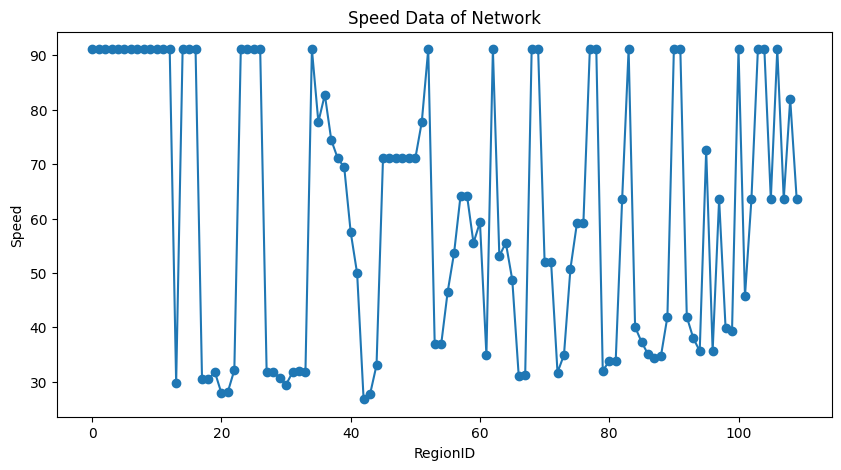

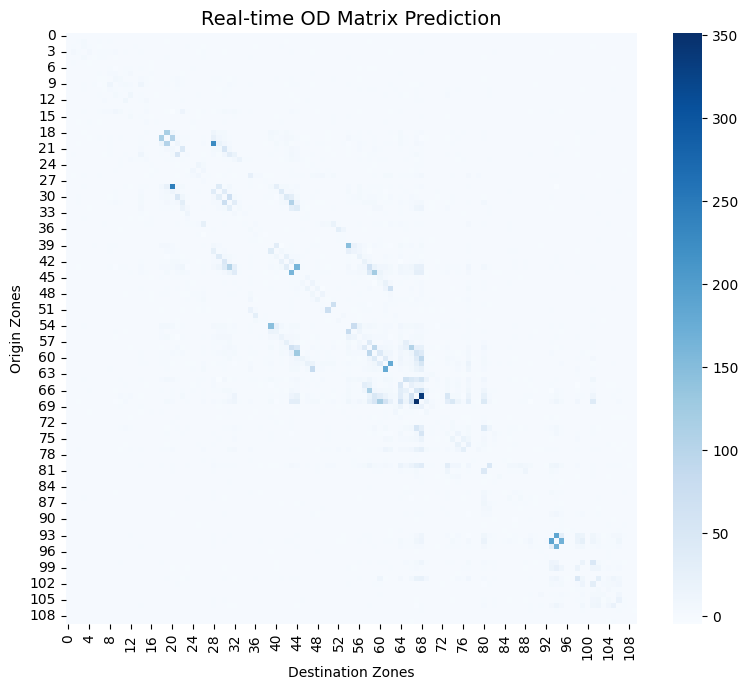

In [13]:
infer_type = 1

realtime_path = 'data/input_road_speed.npy'  # 输入实时的速度数量[N,]，输出估计的OD矩阵[N,N]  N=110
sample = np.load(realtime_path)

if infer_type == 0:
    test_model(model, test_loader, ckpt_path=ckpt_path)
elif infer_type == 1:
    od_pred = realtime_infer(model, sample, scaler=scaler, ckpt_path=ckpt_path)

## 测试集推理

Test Loss (MSE): 39.0080
Test RMSE: 6.0821 Test MAE: 1.1963


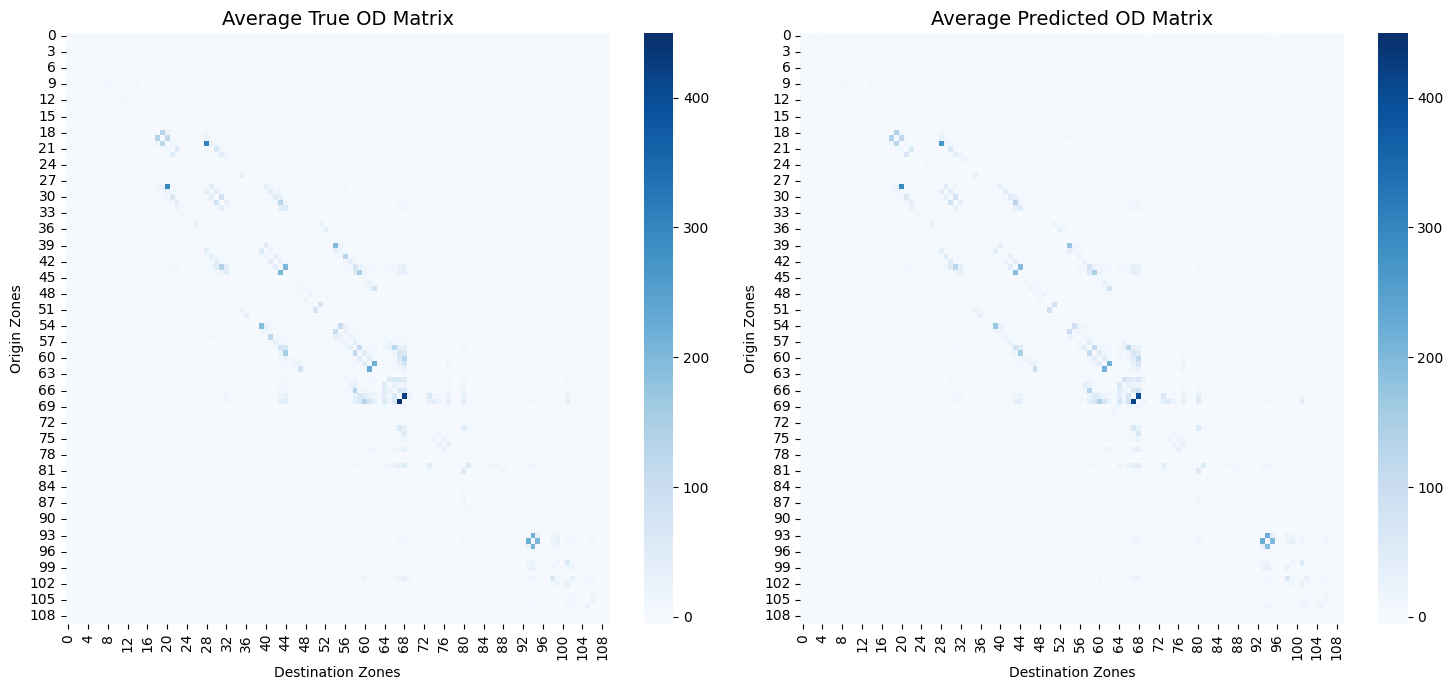

In [19]:
infer_type = 0

if infer_type == 0:
    test_model(model, test_loader, ckpt_path=ckpt_path)
elif infer_type == 1:
    realtime_infer(model, sample, scaler=scaler, ckpt_path=ckpt_path)